## Commuting distance per occupation: analysis
This notebook is to analyse the average distance travelled per occupation across different travel to work areas (TTWA). For each output area (OA), or lower super output area (LSOA) in a TTWA, collected using the LMI for ALL API.

The centroids for each OA, or LSOA, are computed in another script (get_oa_lsoa_centroids) using the ONS postcode directory (February 2019). The same dataset also offers a lookup between OAs and TTWAs.

In [1]:
import urllib.request, json
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns
import copy
from importlib import reload
from pandas.plotting import table
# set the default to darkgrid
sns.set_style('darkgrid')

In [2]:
import os
import itertools
import pandas as pd
import numpy as np 
import pickle
import collections
import seaborn as sns
import scipy

# Python tools
from matplotlib import pyplot as plt
import math
from collections import defaultdict
from functools import partial


In [3]:
%matplotlib inline

In [4]:
# import all filenames (stored in a file that is in common to multiple scripts)
import all_filenames
from all_filenames import *

In [5]:
import utils_pin
from utils_pin import print_elapsed

In [6]:
# imports from the mapping environment
#from sklearn import preprocessing
# plotly
import plotly
import plotly.graph_objs as go
import maputils_pin
from maputils_pin import draw_map, draw_map_and_landmarks

plotly.offline.init_notebook_mode(connected=True)


In [7]:
# plot saving folder
plot_save_dir = '/Users/stefgarasto/Google Drive/Documents/results/PIN/plots/'
# file where I'm storing all the information
save_oa_file = res_folder + 'PIN/oa_distances_and_occupations_v2.pickle'
save_oa_file_jobs = res_folder + 'PIN/oa_jobs_breakdown.pickle'
FIGSAVE = False

In [8]:
# first, load the list of all TTWA
ttwa_data = pd.read_csv(ttwa_file)
# first column is ttwa codes, second column is ttwa names
ttwa_info11 = pd.read_excel(ttwa_info11_file)
ttwa_info16 = pd.read_excel(ttwa_info16_file)
#print(ttwa_info11.tail(n=3))
#print(ttwa_info16.tail(n=3))

# get small TTWAs
small_ttwas = list(ttwa_info11['ttwa11cd'][ttwa_info11['LSOAs']<40])
ni_ttwas = list(ttwa_info11['ttwa11cd'][ttwa_info11['ttwa11cd'].map(lambda x: x[0]=='N')])
print('There are {} TTWAs with less than 40 LSOAs.'.format(len(small_ttwas)+len(ni_ttwas)))

# also, eliminate three scottish TTWAs that seem to mostly have nans:
# just joking: can't eliminate Edinburgh and Aberdeen
#bad_ttwas = []#'S22000059', 'S22000047', 'S22000071']
ni_qual = 'no_ni_'
if ni_qual == 'no_ni_':
    small_ttwas = small_ttwas + ni_ttwas#+ bad_ttwas

# now set the ttwa code as the index
ttwa_data = ttwa_data.set_index('ttwa11cd')
ttwa_info11 = ttwa_info11.set_index('ttwa11cd')
ttwa_info16 = ttwa_info16.set_index('ttwa11cd')

# drop rows
ttwa_data = ttwa_data.drop(small_ttwas, axis = 0)
ttwa_info11 = ttwa_info11.drop(small_ttwas, axis = 0)
ttwa_info16 = ttwa_info16.drop([t for t in small_ttwas if t in ttwa_info16.index], axis = 0)
print(len(ttwa_data),len(ttwa_info11),len(ttwa_info16))
ttwa_data = ttwa_data.sort_index()
ttwa_info16 = ttwa_info16.sort_index()
ttwa_info11 = ttwa_info11.sort_index()

# Create aliases for the column names (need to be shorter to be plotted correctly)
rename_cols16 = {'Employment rate ': 'Employment rate',
       '% of economically inactive who want a job':'Job-seeking economically inactive',
       'Claimant Count, % aged 16-64, April 2015 to March 2016 ': 'Claimant count',
       'All in employment who are 1: managers, directors and senior officials (SOC2010)': 'Employed in SOC code 1',
       ' All in employment who are 2: professional occupations or 3: associate prof & tech occupations (SOC2010)': 
                 'Employed in SOC code 2',
       'All in employment who are 5: skilled trades occupations (SOC2010)': 'Employed in SOC code 5',
       'All in employment who are 6: caring, leisure and other service occupations (SOC2010)': 
                 'Employed in SOC code 6',
       'All in employment who are 8: process, plant and machine operatives (SOC2010)':'Employed in SOC code 8',
       'All in employment who are 9: elementary occupations (SOC2010)':'Employed in SOC code 9'}

rename_cols11 = {'Supply-side self-containment (% employed residents who work locally)':
                 'Supply-side self-containment',
       'Demand-side self-containment (% local jobs taken by local residents)':'Demand-side self containment',
       'Number of economically active residents (aged 16+)':'Economically active residents'}
#ttwa_info16 = 
ttwa_info16.rename(rename_cols16, axis = 1, inplace = True)
#ttwa_info11 = 
ttwa_info11.rename(rename_cols11, axis = 1, inplace = True)



There are 65 TTWAs with less than 40 LSOAs.
166 166 166


In [9]:
# load the extracted dictionaries of OA centroids
loadOA = True
loadLSOA = False
oa_path = ons_der_folder + 'oa_centroids_dictionary.pickle'
lsoa_path = ons_der_folder + 'lsoa_centroids_dictionary.pickle'
exists = os.path.isfile(oa_path)
if exists and loadOA:
    print('Loading the OA data')
    oa_data = pd.read_pickle(oa_path)

exists = os.path.isfile(lsoa_path)
if exists and loadLSOA:
    print('Loading the LSOA data')
    lsoa_data = pd.read_pickle(lsoa_path)


Loading the OA data


In [10]:
# Load the data dictionaries which then should be transformed to dataframes and joined.
# They should also be joined with the list of TTWAs for each OA
# Then, I can make the relevant plots
# What I want is a breakdown of mean travel distances for occupations and for ttwa

# first, load the data
with open(save_oa_file, 'rb') as f:
    _,oa_distances,_,oa_residents,socGroups,_,_ = pickle.load(f)

with open(save_oa_file_jobs, 'rb') as f:
    _,oa_number_of_jobs,oa_jobs_breakdown,jobs_socGroups,_,_ = pickle.load(f)

# create the dataframes from the dictionaries and join the data frames
t0 = time.time()
# first create the residents column and change the column title
oa_frame = pd.DataFrame.from_dict(oa_residents, orient = 'index')
# now add everything else
oa_frame.rename(columns = {0: 'residents'}, inplace = True)
oa_frame = oa_frame.join(
    pd.DataFrame.from_dict(oa_distances, orient = 'index')).join(
    pd.DataFrame.from_dict(oa_number_of_jobs, orient = 'index')).join(
    pd.DataFrame.from_dict(oa_jobs_breakdown, orient = 'index')).join(oa_data)
print('It took {:2f}s to create the full dataframe with {} rows'.format(time.time()- t0, len(oa_frame)))
# finally, rename the number of jobs column
oa_frame.rename(columns = {0: 'residents'}, inplace = True)
# What I should have just created is a dataframe that should have each OA as its index, while the columns are:
# breakdown of mean distances (all, male, female, age groups)
# breakdown of occupations per two digit SOC groups (i.e. how many workers in each TTWA for each occupation, in 
# absolute and relative values)
# latitude, longitude and ttwa
#print(oa_frame.columns,jobs_socGroups)

It took 110.584603s to create the full dataframe with 232032 rows


In [11]:
# group by TTWAs
groups = oa_frame.groupby('ttwa')
# get all the TTWAs - however, exclude the ones that are very small since the data might be inaccurate
all_ttwas = list(ttwa_data.index) #list(set(groups.groups.keys()) - set(small_ttwas))
print(len(all_ttwas))
# Here I'm hardcoding all the occupations
all_occupations = list(jobs_socGroups.keys())
print(all_occupations, len(all_occupations))

166
['350', '213', '354', '125', '113', '341', '711', '119', '421', '927', '353', '412', '522', '721', '415', '221', '356', '247', '111', '242', '413', '323', '924', '543', '241', '231', '115', '622', '614', '416', '313', '411', '612', '342', '222', '215', '811', '122', '912', '821', '712', '624', '621', '344', '331', '321', '212', '814', '531', '246', '243', '713', '623', '223', '211', '926', '925', '813', '812', '532', '524', '244', '116', '112', '913', '911', '823', '822', '613', '523', '521', '511', '214', '722', '544', '542', '541', '533', '525', '355', '352', '351', '312', '311', '245', '124', '121', '118', '117'] 89


In [12]:
A = oa_frame.sample(n=10)
print((oa_frame.index.map(lambda x: x[0]) == oa_frame['ttwa'].map(lambda x: x[0])).sum(),len(oa_frame))
B = oa_frame[oa_frame.index.map(lambda x: x[0]) != oa_frame['ttwa'].map(lambda x: x[0])]
print(ttwa_data.loc[B['ttwa'].value_counts().index])
print((B.index.map(lambda x: x[0])=='N').sum(),len(B))
for a in A.index:
    print('{:.4f},{:.4f}'.format(A['lat'].loc[a],A['long'].loc[a]))
    print(A['Mean distance to work (overall)'].loc[a], a)
    try:
        print(ttwa_data.loc[A['ttwa'].loc[a]]['ttwa11nm'],A['ttwa'].loc[a])
    except:
        print('small one')
    print('--------------------\n')

228711 232032
           objectid                    ttwa11nm  st_areashape  st_lengthshape
K01000013     154.0                     Newport  7.290424e+08   285525.376240
K01000011     152.0                     Chester  7.758495e+08   331897.912770
K01000010     151.0                    Carlisle  2.113080e+09   625210.222422
K01000005     153.0  Cinderford and Ross-on-Wye  5.989980e+08   206164.523430
K01000009     150.0                     Berwick  1.689634e+09   386003.343677
K01000014       NaN                         NaN           NaN             NaN
0 3321
53.8098,-1.5074
6.58730158730159 E00057615
Leeds E30000229
--------------------

54.2874,-0.4375
6.67763157894737 E00141846
Scarborough E30000259
--------------------

50.8426,-0.1335
12.1656050955414 E00085313
Brighton E30000179
--------------------

55.8250,-4.2008
9.15384615384615 S00130404
Glasgow S22000065
--------------------

55.8547,-4.3632
5.85849056603774 S00115511
Glasgow S22000065
--------------------

56.0682,-4.4503

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



In [13]:
# compute the mean distance per occupation per TTWA, by computing a sum over OAs in a given TTWA weighted by the
# percentange of residents in that OA that work in a specific occupation
#M_dist = np.zeros((len(all_occupations),len(all_ttwas)))
M_dist_ttwa = np.zeros(len(all_ttwas))
M_dist_ttwa2 = {}
for jj,ttwa in enumerate(all_ttwas):
    # get the group corresponding to this TTWA
    group = groups.get_group(ttwa)
    # collect the mean distances to work
    dks = np.array(group['Mean distance to work (overall)'])
    # go through all the occupations
    M_dist_ttwa[jj] = np.nanmean(dks)
    M_dist_ttwa2[ttwa] = np.nanmean(dks)
    #for ii,occ in enumerate(all_occupations):
    #    # get the weights, given by the normalised number of how many residents are in this occupation
    #    weights= np.array(group[occ + '_percentage'])
    #    # # set to 0 any weight that is nan
    #    weights[np.isnan(weights)]=0
    #    weights = weights/np.sum(weights)
    #    ## multiply the distances by the normalised weights and sum over the OAs
    #    M_dist[ii,jj] = np.sum(dks * weights)

# TODO: I'm pretty sure this can be optimised, and even left in a dataframe so that I can use seaborn
# what I would want is one column with TTWAs, one with occupation codes, one with the data

# for now, replace nans with mean over column (that is, with the mean for that TTWA)
#col_mean = np.nanmean(M_dist, axis=0)
'''
# Find indices that are NaN
inds = np.where(np.isnan(M_dist))
# Place column means in the indices. Align the arrays using take
M_dist[inds] = np.take(col_mean, inds[1])
'''
## NOPE: for now, also drop TTWA whose mean is nan (there should be none)
#inds_ttwa = np.where(~np.isnan(col_mean))[0]
#M_dist = M_dist[:,inds_ttwa]
inds_ttwa = np.arange(len(ttwa_data))

# collect all names and codes:
ttwa_names = [ttwa_data['ttwa11nm'][ttwa_data.index==t].values[0] for t in all_ttwas]


In [14]:
# Add mean distance across TTWAs to ttwa info dataframes
t0 = time.time()
ttwa_info11['mean_distance'] = np.nan
for row in ttwa_info11.index:
    if row in all_ttwas:
        ix = all_ttwas.index(row)
        ttwa_info11['mean_distance'].loc[row] = M_dist_ttwa[ix] #np.nanmean(M_dist[:,ix])
        print('{:.4f},{:.4f},{:.4f},{}'.format(M_dist_ttwa[ix],M_dist_ttwa2[row],
                                                ttwa_info11['mean_distance'].loc[row],row))
        #if np.isnan(np.mean(M_dist[:,ix])):
        #    print(row, ' is NAN.')
    else:
        continue
#ttwa_info11['mean_distance'] = np.mean(M_dist, axis = 0)
ttwa_info16['mean_distance'] = ttwa_info11['mean_distance']
print_elapsed(t0,'joining mean distances and summary statistics')



/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9.9545,9.9545,9.9545,E30000004
8.3866,8.3866,8.3866,E30000018
8.6375,8.6375,8.6375,E30000029
10.0206,10.0206,10.0206,E30000046
9.5174,9.5174,9.5174,E30000051
12.3706,12.3706,12.3706,E30000054
9.6888,9.6888,9.6888,E30000061
8.5444,8.5444,8.5444,E30000070
9.4384,9.4384,9.4384,E30000076
9.0340,9.0340,9.0340,E30000093
10.9193,10.9193,10.9193,E30000108
8.4026,8.4026,8.4026,E30000110
11.3575,11.3575,11.3575,E30000124
12.7935,12.7935,12.7935,E30000135
12.1526,12.1526,12.1526,E30000159
11.8325,11.8325,11.8325,E30000160
12.2358,12.2358,12.2358,E30000161
8.3985,8.3985,8.3985,E30000162
8.5235,8.5235,8.5235,E30000163
11.8570,11.8570,11.8570,E30000164
9.4573,9.4573,9.4573,E30000165
11.7965,11.7965,11.7965,E30000166
9.1789,9.1789,9.1789,E30000168
8.9034,8.9034,8.9034,E30000169
9.4985,9.4985,9.4985,E30000170
8.0421,8.0421,8.0421,E30000171
11.3073,11.3073,11.3073,E30000172
11.6701,11.6701,11.6701,E30000173
10.1667,10.1667,10.1667,E30000174
8.8199,8.8199,8.8199,E30000175
10.7018,10.7018,10.7018,E300001

In [15]:
main_col16 = ['Male employment rate', 'Female employment rate','Claimant count',
              ' Population','Employed in SOC code 1','Employed in SOC code 9']
main_col11 = ['Supply-side self-containment', 'Demand-side self containment',
       'Land Area (hectares)']

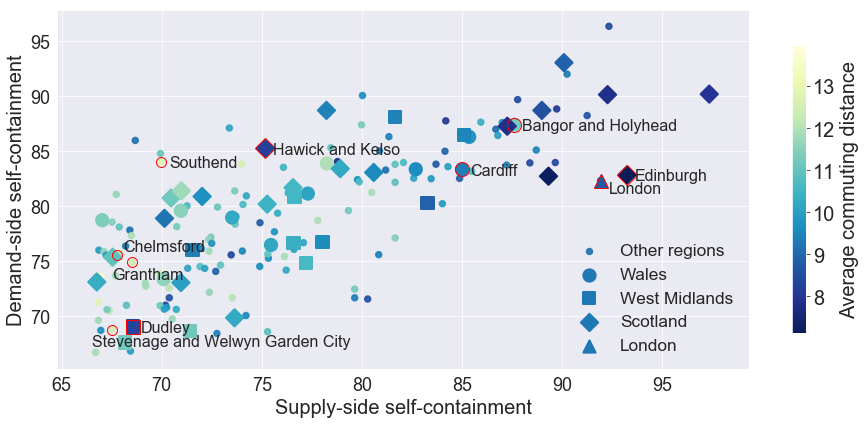

In [60]:
fig = plt.figure(figsize = (13,6))
#g = sns.scatterplot(x='Supply-side self-containment',y='Demand-side self containment',
#               hue = 'mean_distance', data= ttwa_info11, sizes = [20], 
#                palette = 'YlGnBu_r', s = 80)
cmin = np.min(ttwa_info11['mean_distance'])
cmax = np.max(ttwa_info11['mean_distance'])
with sns.axes_style('darkgrid'):
    markerlist = ['o','s','D','^']
    plt.scatter(ttwa_info11['Supply-side self-containment'], ttwa_info11['Demand-side self containment'], 
                              marker = '.',alpha = 0.9,c=ttwa_info11['mean_distance'], s =120,
                               cmap = 'YlGnBu_r', vmin= cmin, vmax = cmax, linewidth = 2)
    for ir, region in enumerate(['Wales','West Midlands', 'Scotland','London']):
        plt.scatter(ttwa_info11['Supply-side self-containment'][ttwa_info16['Region/Country']==region], 
                    ttwa_info11['Demand-side self containment'][ttwa_info16['Region/Country']==region], 
                    c=ttwa_info11['mean_distance'][ttwa_info16['Region/Country']==region], 
                    marker=markerlist[ir], cmap='YlGnBu_r', s= 150, linewidth = 2, vmin= cmin, vmax = cmax)
                              #, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, 
                                #verts=None, edgecolors=None)
    ax = plt.gca()
    ax.set_ylabel('Demand-side self-containment',fontsize = 20, fontname= 'Arial')
    ax.set_xlabel('Supply-side self-containment',fontsize = 20, fontname = 'Arial')
    ax.tick_params(axis = 'both', labelsize = 18)
    cb = plt.colorbar(shrink = 0.8)
    hl = plt.legend(('Other regions','Wales','West Midlands', 'Scotland','London'), loc = 4, fontsize = 'xx-large',
                   frameon = False)
    plt.setp(hl.texts, family='Arial')
    cb.set_label('Average commuting distance', size = 20)
    cb.ax.tick_params(labelsize=20)
    plt.tight_layout()
    
    # highlight some interesting TTWAs
    ttwa_list = ['Edinburgh','Dudley','Cardiff','London','Hawick and Kelso','Bangor and Holyhead',
                'Grantham','Chelmsford','Stevenage and Welwyn Garden City','Southend']
    for ttwa in ttwa_list:
        ix = ttwa_info11['ttwa11nm']==ttwa
        x = ttwa_info11['Supply-side self-containment'][ix]
        y = ttwa_info11['Demand-side self containment'][ix]
        # add red edge around it
        if ttwa in ['London']:
            plt.plot(x,y, marker = '^', markeredgecolor='r', fillstyle = 'none', ms= 14, linewidth = 1.3)
        elif ttwa in ['Edinburgh','Hawick and Kelso']:
            plt.plot(x,y, marker = 'D', markeredgecolor='r', fillstyle = 'none', ms= 14, linewidth = 1.3)
        elif ttwa in ['Cardiff','Bangor and Holyhead']:
            plt.plot(x,y, marker = 'o', markeredgecolor='r', fillstyle = 'none', ms= 14, linewidth = 1.3)
        elif ttwa == 'Dudley':
            plt.plot(x,y, marker = 's', markeredgecolor='r', fillstyle = 'none', ms= 14, linewidth = 1.3)
        else:
            plt.plot(x,y, marker = 'o', markeredgecolor='r', fillstyle = 'none', ms= 10, linewidth = 1.3)
            
        # add TTWA name
        if ttwa in ['London']:
            plt.text(x+.4,y-1.1,ttwa, fontsize = 16, fontname = 'Arial')
        elif ttwa in ['Stevenage and Welwyn Garden City','Grantham']:
            plt.text(x - 1, y - 1.5, ttwa, fontsize = 16, fontname = 'Arial')
        elif ttwa in ['Chelmsford']:
            plt.text(x+.3,y+ .3, ttwa, fontsize= 16, fontname = 'Arial')
        else:
            plt.text(x+.4,y-.5,ttwa, fontsize = 16, fontname = 'Arial')
            
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        
if FIGSAVE or True:
    plt.savefig(os.path.join(plot_save_dir,'demand_vs_supply_by_regions_{}static.png'.format(ni_qual)),
               bbox_inches = 'tight', dpi = 300, quality = 95)

In [17]:
# plot same plot as above but interactive
reload(plotly)
PuOr = sns.color_palette(palette= 'PuOr', n_colors = 256)

fig = {
    'data': [
          {
          'x': ttwa_info11['Supply-side self-containment'], 
            'y': ttwa_info11['Demand-side self containment'], 
            'text': ttwa_info11['ttwa11nm'], 
            'mode': 'markers', 
            'name': 'Demand vs Supply',
            'marker': dict(
                size=16,
                color = ttwa_info11['mean_distance'], #set color equal to a variable
                colorscale='YlGnBu',
                showscale=True
                )
          },
    ],
    'layout': {
        'xaxis': {'title': 'Supply-side self-containment'},
        'yaxis': {'title': "Demand-side self-containment"}
    }
}
plotly.offline.iplot(fig, filename = os.path.join(plot_save_dir,'demand_vs_supply_{}interactive.html'.format(
    ni_qual)))
if FIGSAVE:
    plotly.offline.plot(fig, filename = os.path.join(plot_save_dir,'demand_vs_supply_{}interactive.html'.format(
        ni_qual)), auto_open = False)
                #, image = 'png', image_filename = os.path.join(plot_save_dir,'demand_vs_supply_interactive.html'))
#plotly.io.write_image(fig, file = os.path.join(plot_save_dir,'demand_vs_supply_interactive.png'))
#py.iplot(fig, filename='pandas-multiple-scatter')

In [19]:
show_cols = ['ttwa11nm','Region/Country', 'mean_distance', ' Population', 'Employment rate','Economically inactive',
             'Job-seeking economically inactive',
             'Employed in SOC code 1',
            'Employed in SOC code 1']
#for col in show_cols[1:]:
#    print(ttwa_info16[col].mean())
    # need to change a few strings to nans
#print('The averages for each column are:')
#print([(col, ttwa_info16[col].mean()) for col in show_cols[2:]])
print('\n')
print('The 10 TTWA with the shortest distance are: ')
ttwa_info16[show_cols].sort_values('mean_distance')[:10]





The 10 TTWA with the shortest distance are: 


,ttwa11nm,Region/Country,mean_distance,Population,Employment rate,Economically inactive,Job-seeking economically inactive,Employed in SOC code 1,Employed in SOC code 1
ttwa11cd,,,,,,,,,
S22000059,Edinburgh,Scotland,7.134554,685057.0,72.6,23.3,18.5,10.2,10.2
S22000065,Glasgow,Scotland,7.245998,1256435.0,69.8,25.3,22.4,7.5,7.5
S22000056,Dundee,Scotland,7.823322,240820.0,69.6,24.5,29.4,6.1,6.1
S22000068,Inverness,Scotland,7.854617,117914.0,79.8,18,29.8,7.3,7.3
E30000279,Torquay and Paignton,South West,7.879394,158111.0,76.2,19.6,35,12.6,12.6
S22000047,Aberdeen,Scotland,8.013038,397285.0,79.1,18.4,32,8.7,8.7
E30000171,Blackpool,North West,8.042129,290955.0,71.8,24.1,31.8,9.1,9.1
E30000253,Plymouth,South West,8.106317,354811.0,75.4,20.9,30.2,8.3,8.3
S22000067,Hawick and Kelso,Scotland,8.235996,34169.0,74.7,20,35.4,13.1,13.1


In [20]:
print('The 10 TTWA with the highest distance are: ')
ttwa_info16[show_cols].sort_values('mean_distance')[-10:]


The 10 TTWA with the highest distance are: 


,ttwa11nm,Region/Country,mean_distance,Population,Employment rate,Economically inactive,Job-seeking economically inactive,Employed in SOC code 1,Employed in SOC code 1
ttwa11cd,,,,,,,,,
E30000161,Banbury,East Midlands,12.235796,114722.0,72.7,25.5,12.5,15.7,15.7
E30000218,High Wycombe and Aylesbury,South East,12.321730,412054.0,79.6,16.9,30.1,14.8,14.8
E30000054,Grantham,East Midlands,12.370585,78556.0,74.7,17.8,27.2,10.3,10.3
E30000272,Stevenage and Welwyn Garden City,East of England,12.496728,375958.0,78.0,18.8,19.7,9.2,9.2
E30000242,Medway,South East,12.553398,626275.0,75.3,19.6,24.7,10.6,10.6
E30000268,Southend,East of England,12.793119,581668.0,75.1,21,29,9.9,9.9
E30000135,Thetford and Mildenhall,East of England,12.793514,118112.0,79.2,18.2,11.5,5.3,5.3
E30000221,Huntingdon,East of England,13.330086,170897.0,80.0,16.9,43,7.6,7.6
E30000281,Tunbridge Wells,South East,13.652056,298834.0,76.2,21,24.7,14.2,14.2


In [21]:
def assign_score(x):
    if x['best']:
        return 'Shortest'
    elif x['worst']: #TTWA'] in highest_distance_ttwas:
        return 'Longest'
    else:
        return 'Average'
    
def assign_region(row,ttwa_info):
    region = ttwa_info['Region/Country'].loc[row['TTWA']]
    return region

In [22]:
tmp = ttwa_info16.sort_values('mean_distance')['mean_distance'].values
p = np.percentile(ttwa_info16['mean_distance'].values, 20)
np.sum(tmp<p)/tmp.size
N = int(np.round(len(ttwa_info16)/4))
print(N)

42


In [23]:
# now get the lowest and highest 25th percentile - that is take the bottom and top quarter
N = int(np.round(len(ttwa_info16)/4))
shortest_distance_ttwas = ttwa_info16.sort_values('mean_distance')[:N]['ttwa11nm'].values
shortest_distance_codes = ttwa_info16.sort_values('mean_distance').index[:N].values
highest_distance_ttwas = ttwa_info16[show_cols].sort_values('mean_distance')[-N:]['ttwa11nm'].values
highest_distance_codes = ttwa_info16[show_cols].sort_values('mean_distance').index[-N:].values

In [24]:
# add best and worst indicator to ttwa_info11 and ttwa_info16 too
ttwa_info11 = ttwa_info11.assign(best = [t in shortest_distance_codes for t in ttwa_info11.index])
ttwa_info11 = ttwa_info11.assign(worst = [t in highest_distance_codes for t in ttwa_info11.index])
ttwa_info11['Rank'] = ttwa_info11.apply(assign_score, axis = 1)
# ttwa_info16
#ttwa_info16['best'] = ttwa_info16.reset_index()['ttwa11cd'].apply(lambda x: x in shortest_distance_codes)
ttwa_info16 = ttwa_info16.assign(best = [t in shortest_distance_codes for t in ttwa_info16.index])
ttwa_info16 = ttwa_info16.assign(worst = [t in highest_distance_codes for t in ttwa_info16.index])
ttwa_info16['Rank'] = ttwa_info16.apply(assign_score, axis = 1)
print('Done')

Done


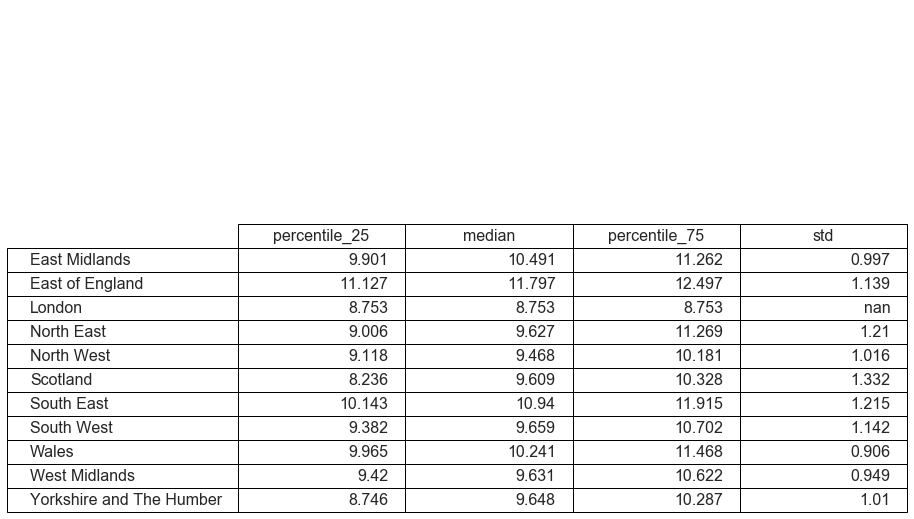

In [25]:
def mypercentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_

tmp = ttwa_info16.groupby('Region/Country')['mean_distance'].aggregate([
    mypercentile(.25), np.median, mypercentile(.75),np.std])
tmp = tmp.applymap(lambda x: np.around(x,3))

# prepare to plot the table: make the rest of the plot invisible
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

# make the table and make it bigger
Tab = table(ax, tmp, fontsize= 16)
Tab.scale(2,2)
Tab.set_fontsize(16)
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_region_stats_{}noSOC.png'.format(ni_qual)),
                bbox_inches = 'tight', dpi = 300, quality = 95)

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



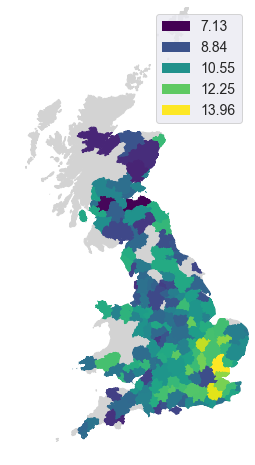

In [26]:
fig,ax = plt.subplots(figsize = (4,8))
_ = draw_map(ttwa_info11.reset_index(), 'mean_distance', 'viridis', 
         np.percentile(ttwa_info11['mean_distance'],0), np.percentile(ttwa_info11['mean_distance'],100), 
             gb_filename,
         None, ttwa_shp_filename, roi_col = 'ttwa11cd', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False})
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_map_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



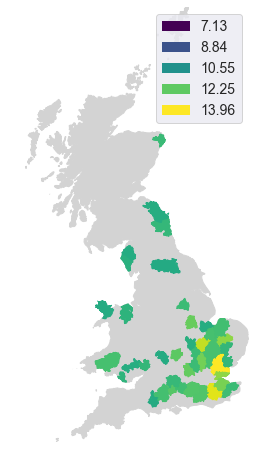

In [29]:
# now, plot mean (or median) commuting distance for each TTWA on a map
fig,ax = plt.subplots(figsize = (4,8))
_ = draw_map(ttwa_info11[ttwa_info11['Rank']=='Longest'].reset_index(), 'mean_distance', 'viridis', 
         np.percentile(ttwa_info11['mean_distance'],0), np.percentile(ttwa_info11['mean_distance'],100), 
             gb_filename,
         None, ttwa_shp_filename, roi_col = 'ttwa11cd', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False})
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_longest_map_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)


/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



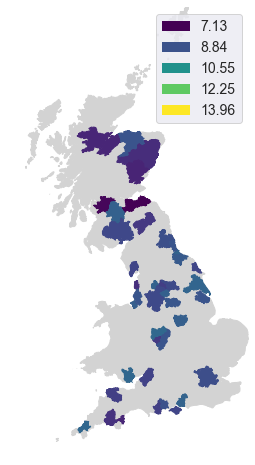

In [30]:
# now, plot mean (or median) commuting distance for each TTWA on a map
fig,ax = plt.subplots(figsize = (4,8))
_ = draw_map(ttwa_info11[ttwa_info11['Rank']=='Shortest'].reset_index(), 'mean_distance', 'viridis', 
         np.percentile(ttwa_info11['mean_distance'],0), np.percentile(ttwa_info11['mean_distance'],100), 
             gb_filename,
         None, ttwa_shp_filename, roi_col = 'ttwa11cd', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False})
if FIGSAVE or True:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_shortest_map_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

#### double checks I've done
- that the LMI for ALL data for each OA has been collected and stored correctly. Manually checked the results for 40 OAs by calling their lat/long values on LMI for ALL
- that each OA has been assigned to the correct TTWA: manually checked 20 lat/long OAs on Google Map
- the procedure to compute the average distances groups correctly by TTWA
- Min and Max in maps correspond to Min and Max in dataframes
- The mean is compute as np.nanmean across all OAs in a TTWA, nothing to do with breakdown by occupation for the report
- check that the correct average distance has been assigned to the correct TTWA in the ttwa_info11 dataframe